In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import standard_sequences.rabi as rabi
import analysis.plotting as plotting
import analysis.analysis as analysis
import standard_sequences.spectroscopy as spec
import standard_sequences.rabi as rabi
import standard_sequences.T1_measurements as T1
import standard_sequences.ramsey as ramsey

In [2]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
C1_address="GPIB0::6::INSTR"
C2_address="GPIB0::10::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc_45"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO_45"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)


In [3]:
q5 = Qubit(q5_dict, readout_dict)
q4 = Qubit(q4_dict, readout_dict)
readout = Readout(readout_dict)
q5.ROIF=q5.ro_freq-readout_dict["RO_LO_45"]
q4.ROIF=q4.ro_freq-readout_dict["RO_LO_45"]
print(f"{q5}\n{q4}")

Qubit(ef_half_amp=None, ge_ssm=-0.087, ro_dur=3000, ge_amp=1, ef_amp=1, IQ_angle=25, ro_amp=0.5, ef_ssm=None, ro_freq=6.44418, ef_time=None, RO_LO_45=6.3804, RO_LO_34=6.4804, ge_time=59, qubit_id=q5, RO_LO_pwr=16, RO_LO=6.6247, ef_half_time=None, RO_IF=None, ROIF=0.06378000000000039, qubit_thr=[-10000, 1900], mixer_offset_ge=2.5, mixer_offset_ef=None)
Qubit(ef_half_amp=None, ge_ssm=-0.252, ro_dur=3000, ge_amp=1, ef_amp=1, IQ_angle=25, ro_amp=0.7, ef_ssm=None, ro_freq=6.51117, ef_time=None, RO_LO_45=6.3804, RO_LO_34=6.4804, ge_time=68, qubit_id=q4, RO_LO_pwr=16, RO_LO=6.6247, ef_half_time=None, RO_IF=None, ROIF=0.13077000000000005, qubit_thr=[-10000, 1900], mixer_offset_ge=2.5, mixer_offset_ef=None)


In [4]:
def spectroscopy(q1,
                 q2,
                 general_vals_dict,
                 f1:float,
                 f2:float,
                 spec_amp:float,
                 num_steps:int,
                 sweep_time:float,
                 reps:int
                 ):
    spec.spectroscopy_ge(
        q1,
        q2,
        general_vals_dict,
        ssm_start=f1,
        ssm_stop=f2,
        spec_amp=spec_amp,
        sweep_time=sweep_time,
        verbose=False,
    )
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )
    return values

def spectroscopy_sweep(q1,
                q2,
                general_vals_dict,
                f1: float,
                f2: float,
                spec_amp: float,
                num_steps: int,
                sweep_time: float,
                reps: int,
                address: str,
                start_voltage: float,
                stop_voltage: float,
                num_points: int,
            ):
   
    sweep_vals = np.linspace(start_voltage, stop_voltage, num_points)
    I1 = np.zeros((num_points, num_steps))
    Q1 = np.zeros((num_points, num_steps))
    I2 = np.zeros((num_points, num_steps))
    Q2 = np.zeros((num_points, num_steps))

    # Run the spectroscopy sweep setup
    spec.spectroscopy_ge(
        q1,
        q2,
        general_vals_dict,
        ssm_start=f1,
        ssm_stop=f2,
        spec_amp=spec_amp,
        sweep_time=sweep_time,
        verbose=False,
    )
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"],
        offset=general_vals_dict["wx_offs"]
    )
    _ = daq.run_daq_het_2q(
            q1,
            q2,
            num_patterns=num_steps,
            num_records_per_pattern=reps,
            verbose=False
        )
    # Main voltage sweep
    for i, voltage in enumerate(sweep_vals):
        bnc.set_DC_output(bnc_addr=address, voltage=voltage)
        # Acquire the raw IQ data
        values = daq.run_daq_het_2q(
            q1,
            q2,
            num_patterns=num_steps,
            num_records_per_pattern=reps,
            verbose=False
        )
        I1[i] = values.rec_avg_vs_pats_1[0]
        Q1[i] = values.rec_avg_vs_pats_1[1]
        I2[i] = values.rec_avg_vs_pats_2[0]
        Q2[i] = values.rec_avg_vs_pats_2[1]

    return I1, Q1, I2, Q2
def run_rabi(
    q1,
    q2,
    general_vals_dict,
    num_steps: int,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the geRabi experiment
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi.rabi_ge(q1, q2, general_vals_dict, num_steps, sweep_time)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})
    return values, IQ_df

def run_T1(
    q1,
    q2,
    general_vals_dict,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the geRabi experiment
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    num_steps=101
    # Run the experiment
    #(qubit1: object, qubit2: object, gen_vals: dict, sweep_time=100000, verbose=True)
    T1.T1(q1, q2, general_vals_dict, sweep_time, verbose=False)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})
    return values, IQ_df

def run_ramsey(
    q1,
    q2,
    general_vals_dict,
    num_steps:int,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the geRabi experiment
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
   
    # Run the experiment
    
    ramsey.ramsey(q1, q2, general_vals_dict,num_steps, sweep_time,verbose=False)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})
    return values, IQ_df

In [19]:
f1=-0.15
f2=-0.05
num_steps=101
reps=1000
spec_amp=.05
sweep_time=5000
freq_list = np.linspace(f1, f2, num_steps)
values=spectroscopy(q5,q4,general_vals_dict,f1,f2,spec_amp,num_steps,sweep_time,reps)
dat = plotting.get_IQ_averages(values)


writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 101
Records per pattern: 1000
Buffers per acquistion: 33
DAQ samples per pattern: 8192
0, No error
Capturing 33 buffers. Press <enter> to abort
Capture completed in 11.147397 sec
Captured 33 buffers (2.960332 buffers per sec)
Captured 101376 records (9094.141152 records per sec)
Transferred 1660944384 bytes (148998408.630038 bytes per sec)


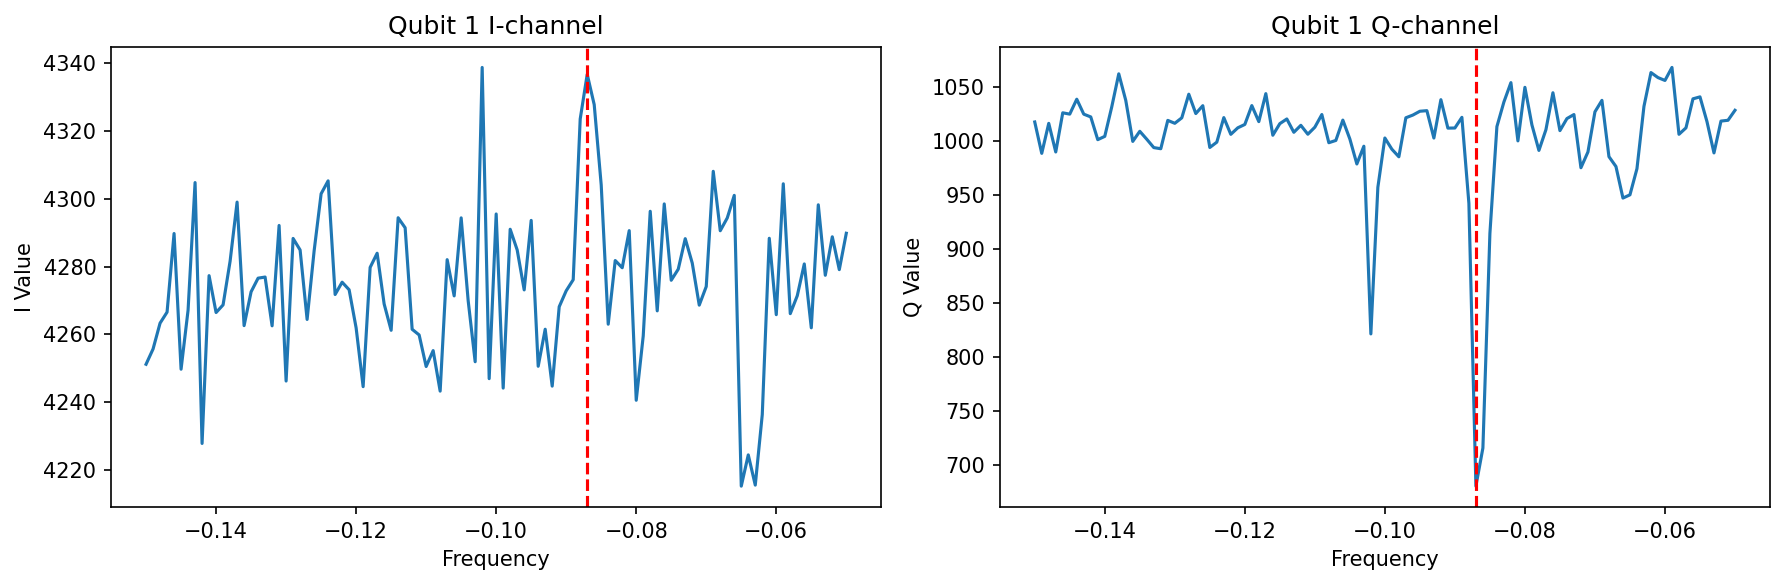

-0.087


In [20]:

freq = freq_list[np.argmin(dat["Q1"])]
plotting.spectroscopy_plot(freq_list, values, [freq, freq], qubit_num=1)
print(freq)

In [ ]:
f1=-0.10
f2=-0.20
num_steps=101
reps=1000
spec_amp=0.05
sweep_time=10000
voltage_start=.5
voltage_stop=-.5#resistor is 300 ohm
voltage_steps = 51
I1,Q1,I2,Q2=spectroscopy_sweep(q5,q4,general_vals_dict,f1,f2,spec_amp,num_steps,sweep_time,reps,C2_address,voltage_start,voltage_stop,voltage_steps)


writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 101
Records per pattern: 1000
Buffers per acquistion: 33
DAQ samples per pattern: 8192
0, No error
Capturing 33 buffers. Press <enter> to abort
Capture completed in 10.877316 sec
Captured 33 buffers (3.033837 buffers per sec)
Captured 101376 records (9319.945800 records per sec)
Transferred 1660944384 bytes (152697991.993751 bytes per sec)
Patterns: 101
Records per pattern: 1000
Buffers per acquistion: 33
DAQ samples per pattern: 8192
0, No error
Capturing 33 buffers. Press <enter> to abort
Capture completed in 10.801013 sec
Captured 33 buffers (3.055269 buffers per sec)
Capture

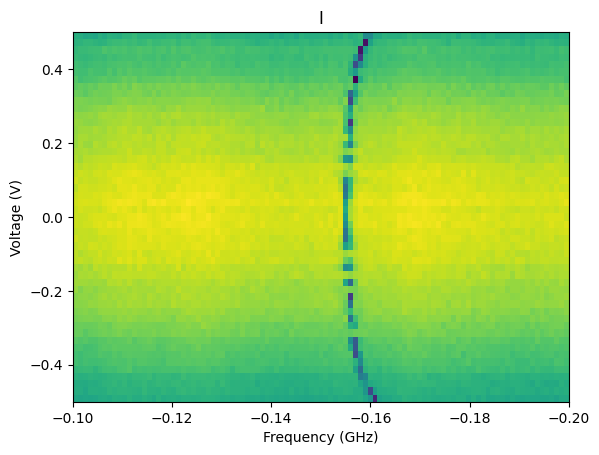

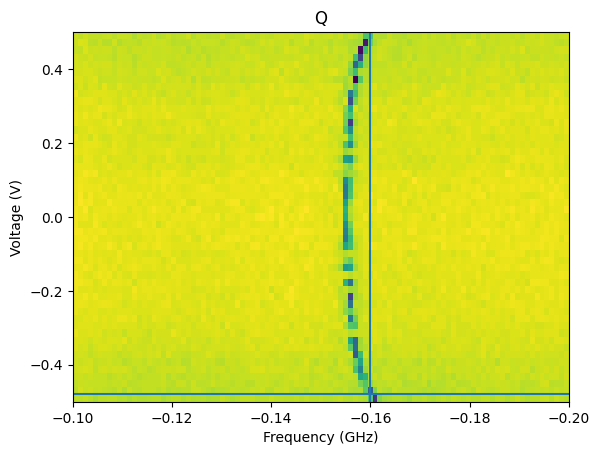

In [28]:
plt.imshow(I1, extent=[f1,f2,voltage_stop,voltage_start],aspect='auto' )
plt.ylabel('Voltage (V)')
plt.xlabel('Frequency (GHz)')
plt.title('I')
plt.show()
plt.imshow(Q1, extent=[f1,f2,voltage_stop,voltage_start],aspect='auto' )
plt.axvline(-0.16)
plt.axhline(-0.48)
plt.ylabel('Voltage (V)')
plt.xlabel('Frequency (GHz)')
plt.title('Q')
plt.show()

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 101
Records per pattern: 500
Buffers per acquistion: 17
DAQ samples per pattern: 8192
0, No error
Capturing 17 buffers. Press <enter> to abort
Capture completed in 6.249523 sec
Captured 17 buffers (2.720207 buffers per sec)
Captured 52224 records (8356.477230 records per sec)
Transferred 855638016 bytes (136912522.933739 bytes per sec)


<Figure size 800x800 with 0 Axes>

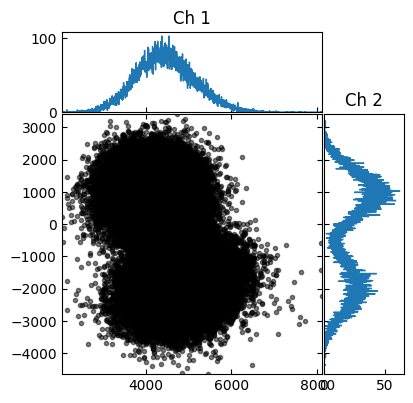

<Figure size 800x800 with 0 Axes>

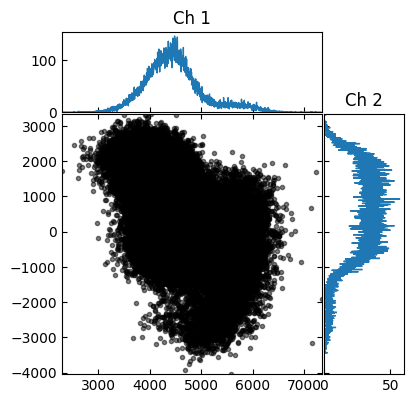

Q


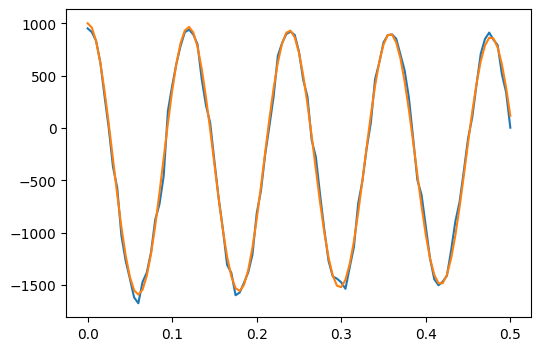



  freq: 8.387848562596353 +/- 0.007859485962602417
 gamma: 0.2218181270086398 +/- 0.04710453655550752
   amp: 1305.5567861277623 +/- 17.31157940002655
 phase: 89.07468285900349 +/- 0.791748651097687
offset: -304.56510807741944 +/- 6.14252161514943
pi_pulse time: 0.059610041391261276 +/- 0.007859485962602417
π_ge time = 59.61004139126128 ns
I


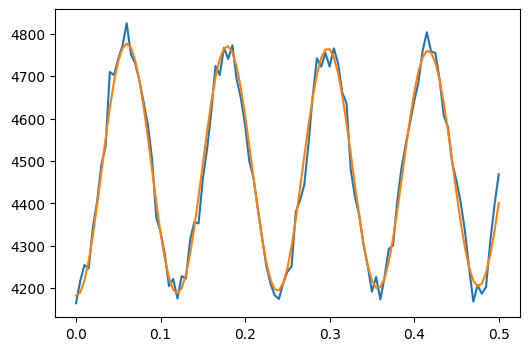



  freq: 8.418427029342553 +/- 0.016128369378334992
 gamma: 0.16042288857079634 +/- 0.09728261123506053
   amp: -298.7074082440438 +/- 8.221004943402384
 phase: 87.77181686457315 +/- 1.6427562266943434
offset: 4480.88418299661 +/- 2.9376217704736534
pi_pulse time: 0.059393518320850505 +/- 0.016128369378334992
π_ge time = 59.393518320850504 ns


In [5]:
num_steps = 101
reps = 500
sweep_time = 500
values, IQ_df = run_rabi(q5,q4,general_vals_dict,num_steps, sweep_time, reps)
IQ_df = plotting.get_IQ_averages(values)
Q = IQ_df["Q1"]
I = IQ_df["I1"]
Qrange = abs(np.max(Q) - np.min(Q))
Irange = abs(np.max(I) - np.min(I))

print("Q")
times = np.linspace(0, sweep_time / 1000, num_steps)
pi_ge_fit_vals, _, _, _ = analysis.fit_sine_decay(
    times, Q, guess_vals=[11, 0.3, np.abs(np.max(Q) - np.min(Q)), 38, Q[0]]
)
pi_ge = abs((1 / 2 / pi_ge_fit_vals[0]) * 1000)
print("\u03C0_ge time = {} ns".format(pi_ge))

print("I")
times = np.linspace(0, sweep_time / 1000, num_steps)
pi_ge_fit_vals, _, _, _ = analysis.fit_sine_decay(
    times, I, guess_vals=[11, 0.3, np.abs(np.max(I) - np.min(I)), 38, I[0]]
)
pi_ge = abs((1 / 2 / pi_ge_fit_vals[0]) * 1000)
print("\u03C0_ge time = {} ns".format(pi_ge))

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 101
Records per pattern: 1000
Buffers per acquistion: 33
DAQ samples per pattern: 8192
0, No error
Capturing 33 buffers. Press <enter> to abort
Capture completed in 20.996946 sec
Captured 33 buffers (1.571657 buffers per sec)
Captured 101376 records (4828.130752 records per sec)
Transferred 1660944384 bytes (79104094.244594 bytes per sec)


<Figure size 800x800 with 0 Axes>

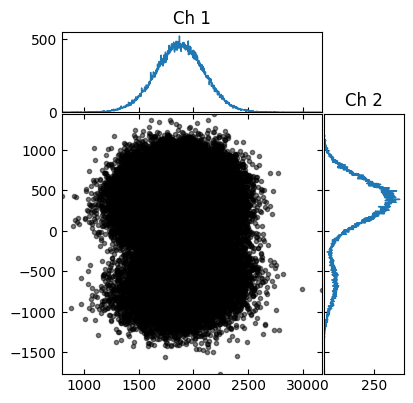

<Figure size 800x800 with 0 Axes>

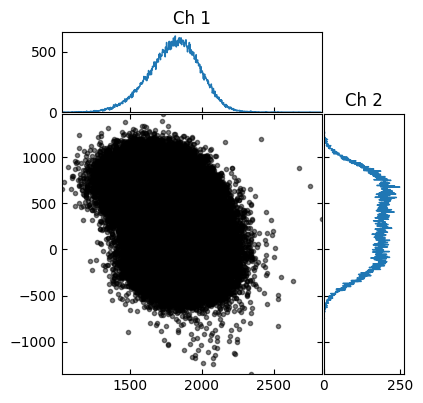

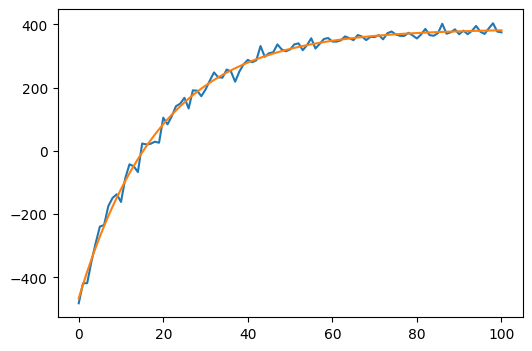



   amp: -851.9545657309452
 gamma: 0.05191628919574121
offset: 385.72548248647263
[-8.51954566e+02  5.19162892e-02  3.85725482e+02]
T1_ge = 19.2617772859242 μs


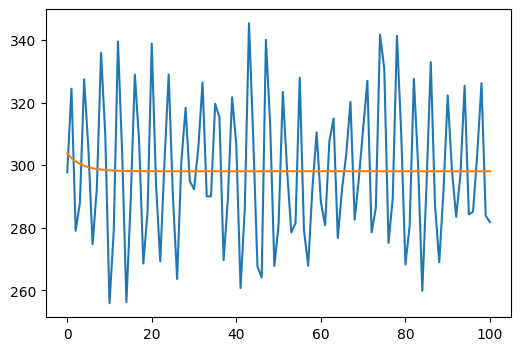



   amp: 5.721753713699947
 gamma: 0.29736314146572324
offset: 298.08364716545213
[5.72175371e+00 2.97363141e-01 2.98083647e+02]
T1_ge = 3.362891564404827 μs


In [6]:
reps = 1000
sweep_time = 100000
values, IQ_df = run_T1(q5,q4,general_vals_dict, sweep_time, reps)
IQ_df = plotting.get_IQ_averages(values)
Q = IQ_df["Q1"]
I = IQ_df["I1"]
Qrange = abs(np.max(Q) - np.min(Q))
Irange = abs(np.max(I) - np.min(I))
times = np.linspace(0, sweep_time / 1000, len(Q))
if Qrange>Irange:
        T1_ge_fit_vals,error_vals,T1_fit_data,_ = analysis.fit_exp_decay(times,Q,guess_vals=[-Qrange,0.5,Q[100]])
else:
        T1_ge_fit_vals,error_vals,T1_fit_data,_ = analysis.fit_exp_decay(times,I,guess_vals=[-Irange,0.5,I[100]])

print(T1_ge_fit_vals)
T1_ge = 1/T1_ge_fit_vals[1]
print("T1_ge = {} \u03BCs".format(T1_ge))
Q = IQ_df["Q2"]
I = IQ_df["I2"]
Qrange = abs(np.max(Q) - np.min(Q))
Irange = abs(np.max(I) - np.min(I))
times = np.linspace(0, sweep_time / 1000, len(Q))
if Qrange>Irange:
        T1_ge_fit_vals,error_vals,T1_fit_data,_ = analysis.fit_exp_decay(times,Q,guess_vals=[-Qrange,0.5,Q[100]])
else:
        T1_ge_fit_vals,error_vals,T1_fit_data,_ = analysis.fit_exp_decay(times,I,guess_vals=[-Irange,0.5,I[100]])

print(T1_ge_fit_vals)
T1_ge = 1/T1_ge_fit_vals[1]
print("T1_ge = {} \u03BCs".format(T1_ge))

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 101
Records per pattern: 1000
Buffers per acquistion: 33
DAQ samples per pattern: 8192
0, No error
Capturing 33 buffers. Press <enter> to abort
Capture completed in 14.243972 sec
Captured 33 buffers (2.316769 buffers per sec)
Captured 101376 records (7117.115897 records per sec)
Transferred 1660944384 bytes (116606826.849017 bytes per sec)


<Figure size 800x800 with 0 Axes>

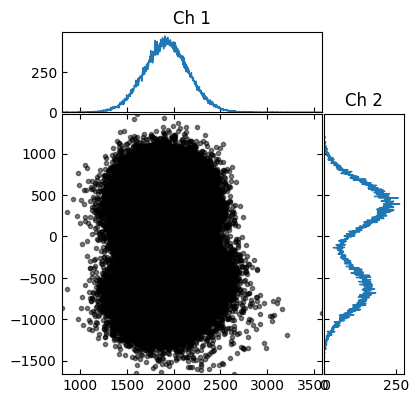

<Figure size 800x800 with 0 Axes>

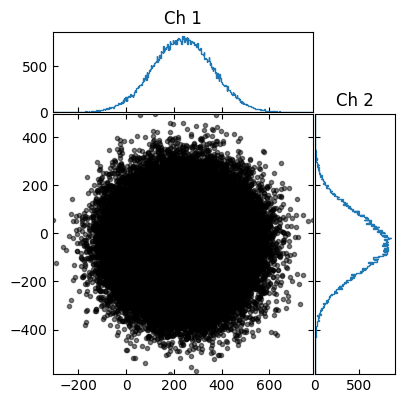

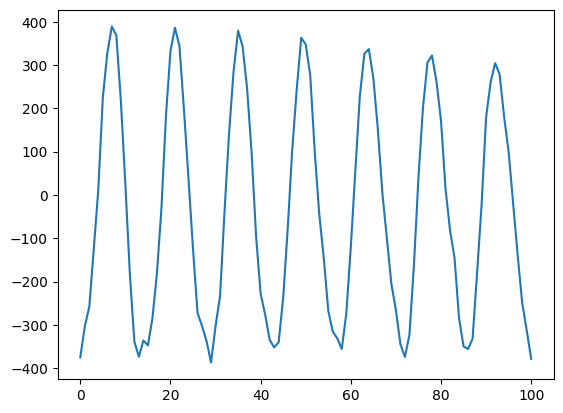

RuntimeError


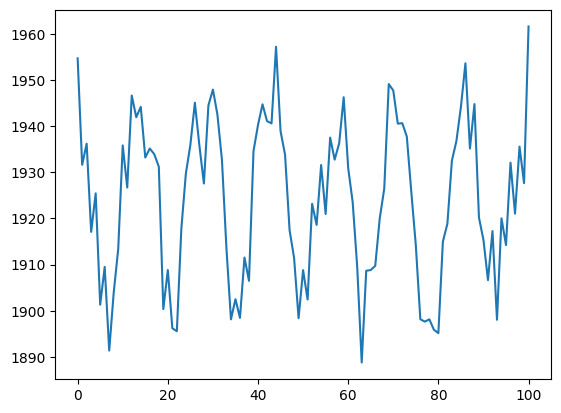

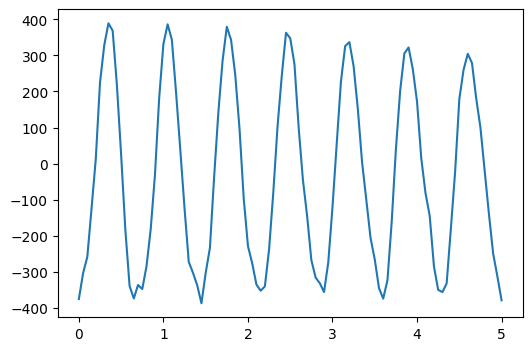



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
T2* = nan μs


In [ ]:
q5.ge_ssm=-0.085
reps = 1000
sweep_time = 5000
num_steps = 101
values, IQ_df= run_ramsey(q5,q4,general_vals_dict,num_steps, sweep_time, reps)
IQ_df = plotting.get_IQ_averages(values)
Q = IQ_df["Q1"]
I = IQ_df["I1"]
plt.plot(Q)
plt.show()
plt.plot(I)
Qrange = abs(np.max(Q) - np.min(Q))
Irange = abs(np.max(I) - np.min(I))
times = np.linspace(0, sweep_time / 1000, len(Q))

T2_fit_vals,_,_,_ = analysis.fit_sine_decay(times,Q,guess_vals=[0.1 ,0.04600696770461763,-67.76128980276253,-263.4006117568909,0])
T2 = 1/T2_fit_vals[1]
print("T2* = {} \u03BCs".format(T2))
T2_fit_vals,_,_,_ = analysis.fit_sine_decay(times,I,guess_vals=[0 ,0.04600696770461763,-67.76128980276253,-263.4006117568909,0])
T2 = 1/T2_fit_vals[1]
print("T2* = {} \u03BCs".format(T2))

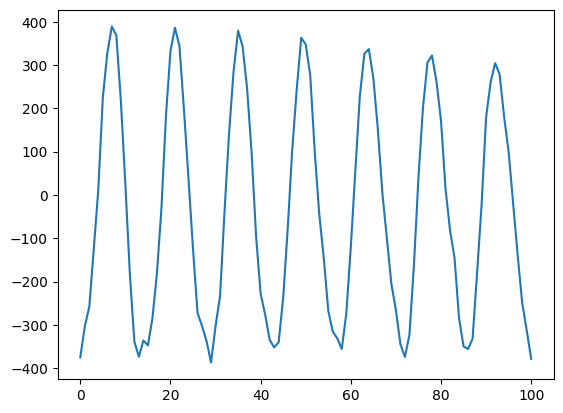

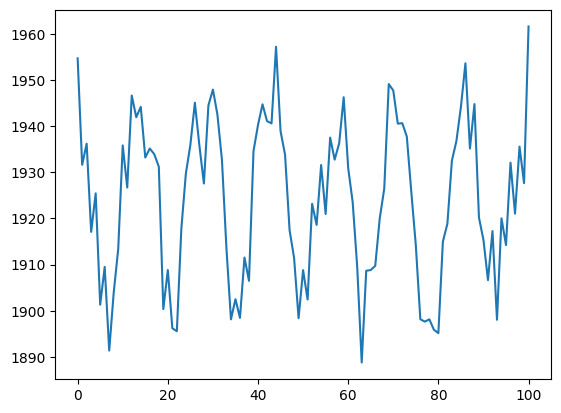

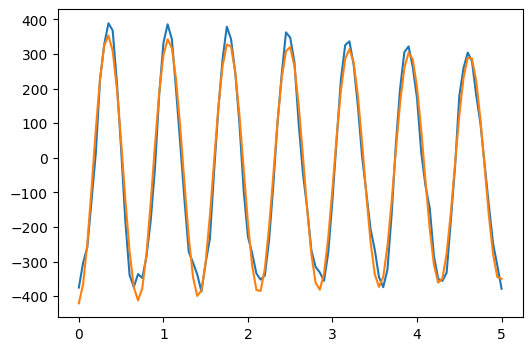



  freq: 1.402605730309474 +/- 0.0017132962143413736
 gamma: 0.03795859857450834 +/- 0.010338282250497662
   amp: -390.7908580114808 +/- 11.19773633590868
 phase: -264.2228632071643 +/- 1.6855184168627082
offset: -31.784735327864503 +/- 3.87033941723575
pi_pulse time: 0.3564793649386267 +/- 0.0017132962143413736
T2* = 26.344492092802522 μs


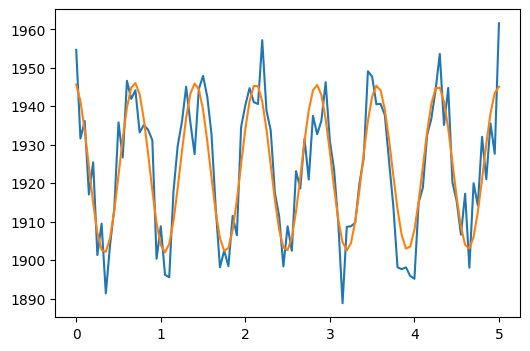



  freq: 1.3934620439670085 +/- 0.005989184196972503
 gamma: 0.011176522741385702 +/- 0.036742120098213
   amp: 22.273668679365667 +/- 2.3495953672469834
 phase: 2624.028074642086 +/- 6.103854102071802
offset: 1924.019311272917 +/- 0.8320289446174669
pi_pulse time: 0.35881852840179546 +/- 0.005989184196972503
T2* = 89.47326669833419 μs


In [16]:
Q = IQ_df["Q1"]
I = IQ_df["I1"]
plt.plot(Q)
plt.show()
plt.plot(I)
Qrange = abs(np.max(Q) - np.min(Q))
Irange = abs(np.max(I) - np.min(I))
times = np.linspace(0, sweep_time / 1000, len(Q))

T2_fit_vals,_,_,_ = analysis.fit_sine_decay(times,Q,guess_vals=[0.1 ,0.04600696770461763,-67.76128980276253,-263.4006117568909,0])
T2 = 1/T2_fit_vals[1]
print("T2* = {} \u03BCs".format(T2))
T2_fit_vals,_,_,_ = analysis.fit_sine_decay(times,I,guess_vals=[0 ,0.04600696770461763,-67.76128980276253,-263.4006117568909,0])
T2 = 1/T2_fit_vals[1]
print("T2* = {} \u03BCs".format(T2))